In [30]:
import numpy as np
from params import params
from defi.amm import amm
import cvxpy as cp
from scipy.linalg import sqrtm
from scipy.stats import norm
import matplotlib.pyplot as plt
from defi.utils import get_var_cvar_empcdf

In [54]:
weights = [0.13236412405967712, 0.20837844908237457, 0.1833776980638504, 0.21926841139793396, 0.23566870391368866, 0.020942607894539833]
returns = generate_returns({**params, 'weights': np.array(weights)})
get_var_cvar_empcdf(returns, params['alpha'], params['zeta'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.73it/s]


(-0.03274833848558981, 0.0040099495164827425, array(0.842))

In [2]:
params['weights'] = np.repeat(1/params['N_pools'], params['N_pools'])

def generate_returns(params):
    
    np.random.seed(params['seed'])
    pools = amm(Rx=params['Rx0'], Ry=params['Ry0'], phi=params['phi'])

    xs_0 = params['weights'] * params['x_0']
    l = pools.swap_and_mint(xs_0)

    end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(params['kappa'], params['p'], params['sigma'], T=params['T'], batch_size=params['batch_size'])

    x_T = np.array([end_pools[k].burn_and_swap(l) for k in range(params['batch_size'])])
    
    return np.log(x_T) - np.log(params['x_0'])

returns = []

for i in range(params['N_pools']):
    weights = np.repeat(0.0001, 6)
    weights[i] = 0.9995
    returns += [generate_returns({**params, 'weights': weights})]
    
returns = np.array(returns)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.65it/s]


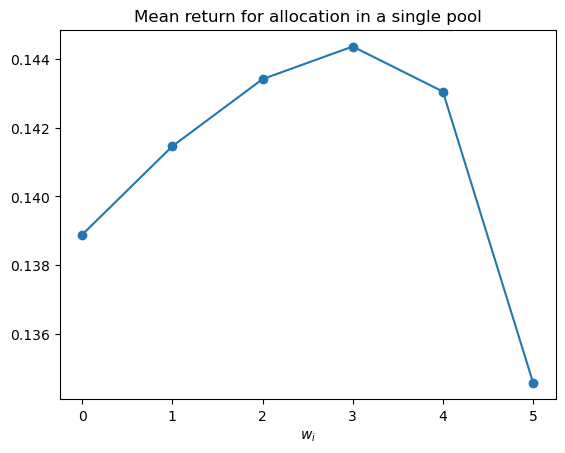

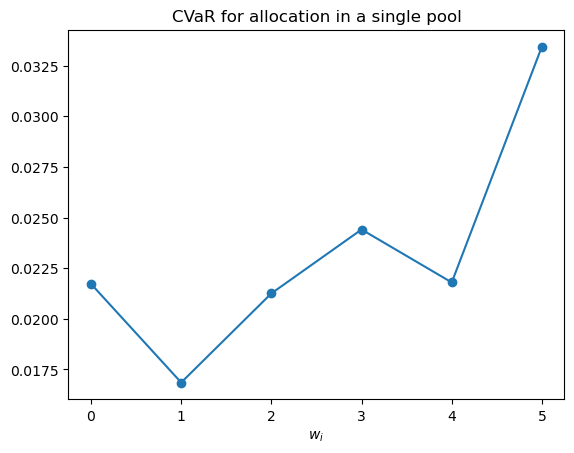

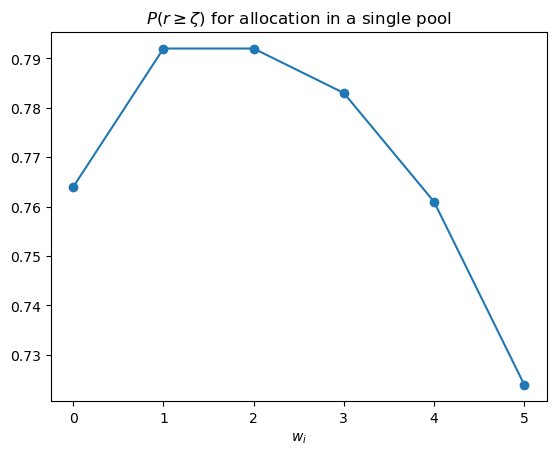

In [43]:
fig, ax = plt.subplots()
ax.plot([np.mean(ret) for ret in returns], marker='o')
ax.set_xlabel('$w_i$')
ax.set_title('Mean return for allocation in a single pool')
fig.savefig('_plots/mean_return_wi.pdf')

fig, ax = plt.subplots()
results = np.array([get_var_cvar_empcdf(ret, params['alpha'], params['zeta']) for ret in returns])
ax.plot(results[:, 1], marker='o')
ax.set_xlabel('$w_i$')
ax.set_title('CVaR for allocation in a single pool')
fig.savefig('_plots/cvar_wi.pdf')

fig, ax = plt.subplots()
results = np.array([get_var_cvar_empcdf(ret, params['alpha'], params['zeta']) for ret in returns])
ax.plot(results[:, 2], marker='o')
ax.set_xlabel('$w_i$')
ax.set_title('$P(r \geq \zeta)$ for allocation in a single pool')
fig.savefig('_plots/p_wi.pdf')